In [1]:
import numpy as np
import scipy.optimize as optim
import math
import os,sys
import pandas as pd
import copy
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as st
from scipy.stats import t

import BA_C

from sklearn.metrics import auc

In [2]:
def linear(x,a,b):
    return (a + b*x)

In [3]:
data_folder = '/Users/sns9/CodeX/ProVia/data/Annexin'
os.chdir(data_folder)

x_dict = {}
x_dict['AH'] = 'Healthy cells (%)'
x_dict['AN'] = 'Necrotic cells (%)'
x_dict['AEA'] = 'Early Apoptotic cells (%)'
x_dict['AH'] = 'Healthy cells (%)'

In [4]:
v24 = pd.read_csv('all-Annexin24h-for-analysis-5.csv')
#v24 = pd.read_csv('Annexin24h-summary.csv')

print(list(v24))

name_tag = {}

name_tag['AH'] = 'Healthy cells (%)'
name_tag['AEA'] = 'Early apoptotic cells (%)'
name_tag['ALA'] = 'Late apoptotic cells (%)'
name_tag['AN'] = 'Necrotic cells (%)'

experiment_name = v24['Experiment name'].dropna().to_list()

print(experiment_name)

['AODAPI', 'AH', 'AEA', 'ALA', 'AN', 'Experiment name']
['Annexin-1-2', 'Annexin-3-4', 'Annexin-5-6', 'Annexin-10-11', 'Annexin-12-13']


In [5]:
#weight1 = pd.Series([0.2, 0.3, 0.4, 0.5, 0.75, 0.95])
weight1 = pd.Series([0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9])
colors1 = weight1.apply(lambda x: (0,0,0,x)).tolist()

In [6]:
all_data = {}

for n in list(v24):
    all_data[n] = v24[n].to_numpy()

#all_data['T2'] = 76.76*np.power(all_data['AODAPI']/100,-2.4)
all_data['T2'] = 81.61*np.power(all_data['AODAPI']/100,-1.8)

print(all_data['T2'])

[ 86.18366332  87.92500295  89.84648275 110.00123526 115.97912049
 180.89372565 158.63760854  84.56333943  84.42062572  85.65138566
  90.09609506  94.69099903 116.54978838 243.81197927  85.82288237
  87.95048031  86.32561598  86.88472762  95.22360242  96.51933228
 178.32747476  84.63235808  84.63235808  84.63235808  86.20932728
  86.20932728  98.65221957 167.80648213  83.09980938  87.83248261
  87.83248261  89.50367925  92.99809886 104.85972711 143.80110711]


In [7]:
tag = 'ALA'

result = st.linregress(all_data[tag],all_data['T2'],alternative='two-sided')
print(result)

r_text = r'$\mathrm{R}^2 = ' + str(round(result.rvalue**2,3)) + '$'

LinregressResult(slope=1.9320101410605384, intercept=72.41589157204606, rvalue=0.6987838863880179, pvalue=3.031277498838654e-06, stderr=0.34428469499371595, intercept_stderr=7.582495010669461)


In [8]:
results = optim.curve_fit(linear,all_data[tag],all_data['T2'],absolute_sigma=False,full_output=True)

popt, pcov = results[0], results[1]

p_std = np.sqrt(np.diag(pcov))

print(popt)
print(pcov)

#fitname = r'T2$_{\mathrm{est}}$ = exp(' + str(round(popt[0],3)) + ' - ' + str(round(popt[1],3)) + '$(100-C)$)'

fitname = r'T2$_{\mathrm{est}}$ = ' + str(round(popt[0],3)) + ' + ' + str(round(abs(popt[1]),3)) + tag

[72.41589154  1.93201014]
[[57.49422952 -2.09375683]
 [-2.09375683  0.11853195]]


In [9]:
dof = len(all_data['T2']) - 2
    
tinv = lambda p, df: abs(t.ppf(p/2,df))
ts = tinv(0.05,dof)

s_err = ts*result.stderr
i_err = ts*result.intercept_stderr

In [10]:
residual = linear(all_data[tag],popt[0],popt[1]) - all_data['T2']

norm_RSS = math.sqrt(np.dot(residual,residual)/(len(all_data['T2'])-2))
print(norm_RSS)

RSS_text = r's.d. = ' + str(round(norm_RSS,2)) + ' h'

26.79269675754325


fitname = r'T2$_{\mathrm{est}}$ = (' + str(round(result.intercept,1)) + '$\pm$' + str(round(i_err,1)) + ')'
fitname += '+ (' + str(round(result.slope,1)) + '$\pm$' + str(round(s_err,1)) + ')'+ name_tag[tag]

print(fitname)

In [11]:
d = all_data[tag]
mean_x = np.linspace(0.8*np.min(d),1.2*np.max(d),100)
mean_t2 = linear(mean_x,popt[0],popt[1])

In [12]:
n_samples = 10000

s_is, i_is = [], []

t2_up = np.zeros(shape=mean_x.shape)
t2_low = np.zeros(shape=mean_x.shape)

rt2_up = np.zeros(shape=mean_x.shape)
rt2_low = np.zeros(shape=mean_x.shape)

effective_sigma = np.zeros(shape=mean_x.shape)

for i in range(0,mean_x.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(linear(mean_x[i],a_sample,b_sample))
        
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
        
    t2_low[i], t2_up[i] = mean_t2[i] - ci95, mean_t2[i] + ci95
    
    rt2_low[i], rt2_up[i] = mean_t2[i] - sigma*ts, mean_t2[i] + sigma*ts

In [13]:
# Number of points in each set
n = 7

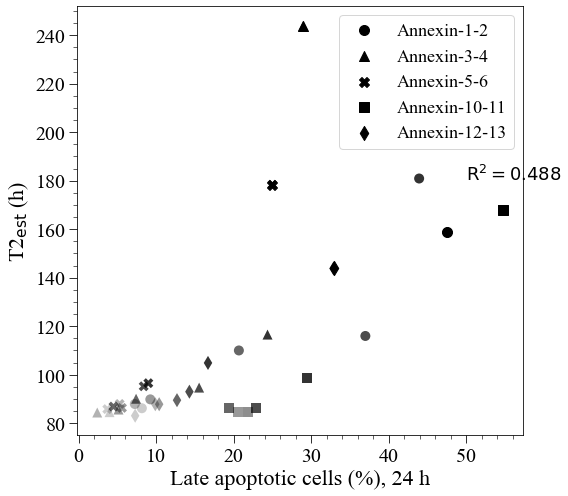

In [14]:
fig, axs = plt.subplots(figsize=(8,7))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

#plt.errorbar(v0[:,0],v0[:,3],v0[:,4],v0[:,1],fmt='o',lw=2,alpha=0.5,mew=2,ms=10,color='#000000',capsize=5,capthick=1,label='0 h')
plt.scatter(all_data[tag][:n],all_data['T2'][:n],marker='o',linewidth=0,s=100,c=colors1)
plt.scatter(all_data[tag][n:2*n],all_data['T2'][n:2*n],marker='^',linewidth=0,s=100,c=colors1)
plt.scatter(all_data[tag][2*n:3*n],all_data['T2'][2*n:3*n],marker='X',linewidth=0,s=100,c=colors1)
plt.scatter(all_data[tag][3*n:4*n],all_data['T2'][3*n:4*n],marker='s',linewidth=0,s=100,c=colors1)
plt.scatter(all_data[tag][4*n:],all_data['T2'][4*n:],marker='d',linewidth=0,s=100,c=colors1)

plt.scatter(all_data[tag][n-1],all_data['T2'][n-1],marker='o',s=100,c='black',label=experiment_name[0])
plt.scatter(all_data[tag][2*n-1],all_data['T2'][2*n-1],marker='^',s=100,c='black',label=experiment_name[1])
plt.scatter(all_data[tag][3*n-1],all_data['T2'][3*n-1],marker='X',s=100,c='black',label=experiment_name[2])
plt.scatter(all_data[tag][4*n-1],all_data['T2'][4*n-1],marker='s',s=100,c='black',label=experiment_name[3])
plt.scatter(all_data[tag][-1],all_data['T2'][-1],marker='d',s=100,c='black',label=experiment_name[4])

#plt.plot(mean_x,mean_t2,alpha=0.6,lw=4,color='#660000')
#plt.fill_between(mean_x,t2_up,t2_low,alpha=0.15,color='#660000',linewidth=0.0)
#plt.fill_between(mean_x,rt2_up,rt2_low,alpha=0.2,color='#000066',linewidth=0.0)

#plt.plot(aa1,T2aa1,linewidth=3,color='#000000',alpha=0.4,label='Study 1')#,label=r'$(239.8 \pm 25.8) - (2.15 \pm 0.51)[A_H]$')
#plt.plot(aa2,T2aa2,linewidth=3,color='#000000',alpha=0.4,ls='--',label='Study 2')

plt.xticks(size=20)
plt.yticks(size=20)  
plt.xlabel(name_tag[tag]+', 24 h',size=22)
plt.ylabel(r'T2$_{\mathrm{est}}$ (h)',size=22,rotation=90)
plt.minorticks_on()
#plt.xlim(90,100)
#plt.ylim(50,200)
axs.tick_params(which='major', length=8)
axs.tick_params(which='minor', length=4)
plt.legend(frameon=True,prop={'size': 18},markerscale=1.0,handlelength=2.0,loc='upper right')
plt.text(50,180,r_text,fontsize=18)
#plt.text(5,210,RSS_text,fontsize=20)

#plt.plot(np.linspace(7,9,2),26*np.ones(2,),color='#660000',alpha=0.7,lw=3)
#plt.text(10,24,fitname,fontsize=18)

#axs.invert_xaxis()

plt.tight_layout()

#plt.savefig('Annexin-'+tag+'-24h-vs-T2-from-AODAPI-v3.png',dpi=600)
#plt.savefig(tag+'-24h-noAODAPI-3s.png',dpi=300)

In [15]:
data_folder = '/Users/sns9/CodeX/ProVia/data/cutoff'
os.chdir(data_folder)

# False positivity rate
pvalue = 0.5

T2_cutoff = np.zeros(shape=mean_x.shape)

wf = open(tag+'_t2_mean.csv','w')

for i in range(0,mean_x.shape[0]):
    T2_cutoff[i] = st.t.ppf(1-pvalue,df=dof,loc=mean_t2[i],scale=effective_sigma[i])
    
    print(str(mean_x[i])+','+str(T2_cutoff[i]),file=wf)
    
wf.close()

data_folder = '/Users/sns9/CodeX/ProVia/data/Annexin'
os.chdir(data_folder)

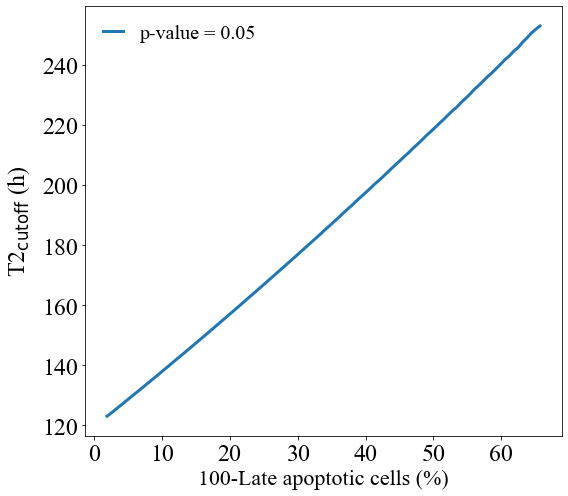

In [16]:
#fig, axs = plt.subplots(figsize=(8,7))
fig, axs = plt.subplots(figsize=(8,7))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

plt.plot(mean_x,T2_cutoff,lw=3.0,label=r'p-value = 0.05')
        
plt.xticks(size=24)
plt.yticks(size=24)  
plt.xlabel('100-'+name_tag[tag],size=22)
plt.ylabel(r'T2$_{\mathrm{cutoff}}$ (h)',size=24,rotation=90,labelpad=10)
#plt.xlim(50,100)
#plt.ylim(0,1.75)
plt.legend(frameon=False,prop={'size': 20,'family':'Times New Roman'},markerscale=1.0,handlelength=1.0,loc='best')

#plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()

#plt.savefig('AODAPI-T2-cutoff_prob-v2.png',dpi=300)

In [19]:
mean_x2 = np.linspace(np.min(mean_x),np.max(mean_x),1000)

n_samples = 10000

s_is, i_is = [], []

t2 = np.zeros(shape=mean_x2.shape)

t2_up = np.zeros(shape=mean_x2.shape)
t2_low = np.zeros(shape=mean_x2.shape)

rt2_up = np.zeros(shape=mean_x2.shape)
rt2_low = np.zeros(shape=mean_x2.shape)

effective_sigma = np.zeros(shape=mean_x2.shape)

for i in range(0,mean_x2.shape[0]):
    samples = []
    
    a_samples, b_samples = np.random.multivariate_normal(popt,pcov,n_samples).T
    
    t2[i] = linear(mean_x2[i],popt[0],popt[1])
        
    for a_sample,b_sample in zip(a_samples,b_samples):
        samples.append(linear(mean_x2[i],a_sample,b_sample))
        
    #ci = st.norm.interval(alpha=0.95, loc=np.mean(samples), scale=np.std(samples))
    
    sigma = np.std(samples)
    
    effective_sigma[i] = math.sqrt(sigma**2 + norm_RSS**2)
    
    ci95 = effective_sigma[i]*ts
    
    #t2_low[i], t2_up[i] = ci[0], ci[1]
    
    t2_low[i], t2_up[i] = t2[i] - ci95, t2[i] + ci95
    
    rt2_low[i], rt2_up[i] = t2[i] - effective_sigma[i], t2[i] + effective_sigma[i]

In [20]:
#test_t2s = [100,150,200,250,300]
test_t2s = [96,108,120,132,144,156,168,180,192,204,216,228,240,252,264]
#test_t2s = [96,120,144,168,192,216,240,264]
#test_t2s = [96,144,192,240]
#test_t2s.reverse()
#print(test_t2s)
#test_t2s = list(np.linspace(72,264,16))

#test_t2s = list(np.linspace(96,264,3))
print(test_t2s[1] - test_t2s[0])
#test_t2s.reverse()

cutoff_probs = {}
pdfs = {}
cdfs = {}

for k in test_t2s:
    cutoff_probs[k] = np.zeros(shape=mean_x2.shape)
    pdfs[k] = np.zeros(shape=mean_x2.shape)
    cdfs[k] = np.zeros(shape=mean_x2.shape)
    
responses = np.zeros(shape=(len(test_t2s),mean_x2.shape[0]))

j = 0

for k in test_t2s:
    for i in range(0,mean_x2.shape[0]):
        cutoff_probs[k][i] = st.t.sf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        pdfs[k][i] = st.t.pdf(k,df=dof,loc=t2[i],scale=effective_sigma[i])
        
    pdfs[k] *= 1.0/np.sum(pdfs[k])
    
    x = copy.deepcopy(pdfs[k])#[::-1])
    cdfs[k] = np.round(np.array([np.sum(x[m:]) for m in range(0,pdfs[k].shape[0])]),3)
    
    responses[j,:] = pdfs[k]
    
    j += 1
    
c, e, p = BA_C.get_CC(responses)
print(c)

12
0.9215926318821847


In [ ]:
fig = plt.figure(tight_layout=True,figsize=(15,10))
gs = fig.add_gridspec(len(test_t2s),3, hspace=0)

ax = fig.add_subplot(gs[:,0])
ax.plot(mean_x2,t2,linewidth=4,color='#660000',alpha=0.6,label=fitname)
ax.fill_between(mean_x2,t2_up,t2_low,alpha=0.15,color='#660000',linewidth=0.0)
ax.fill_between(mean_x2,rt2_up,rt2_low,alpha=0.2,color='#660000',linewidth=0.0)

ax.set_title(r'T2$_{\mathrm{est}}$-vs-ALA',size=22,pad=10)

ax.tick_params(axis='both',labelsize=24)
ax.set_yticks(test_t2s)
#ax.yticks(size=24)  
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
ax.set_xlabel(r'ALA (%), 24 h',size=24,labelpad=10)
ax.set_ylabel(r'T2$_{\mathrm{est}}$ (h)',size=24,rotation=90,labelpad=10)
ax.set_ylim(75,275)
ax.set_xlim(np.min(mean_x2),np.max(mean_x2))

for t in test_t2s:
    _alpha = 0.25 + 0.75*(t - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(mean_x2,t*np.ones(shape=mean_x2.shape[0]),color='black',lw=3,alpha=_alpha)

for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,1])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(mean_x2,cutoff_probs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    ax.tick_params(axis='y',labelsize=12)
    ax.set_ylim(-0.02,1.2)
    ax.set_xlim(np.min(mean_x2),np.max(mean_x2))
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title(r'P[T2$_{\mathrm{est}}$ $\geq$ T2$_{\mathrm{cutoff}}$]',size=22,pad=10)
        
ax.set_xlabel(r'ALA (%), 24 h',size=24,labelpad=10)
        
for k in range(len(test_t2s)):
    ax = fig.add_subplot(gs[k,2])
    
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    ax.plot(mean_x2,pdfs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    ax.tick_params(axis='y',labelsize=12)
    #ax.set_ylim(-0.02,1.2)
    ax.set_xlim(np.min(mean_x2),np.max(mean_x2))
    ax.legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    ax.set_ylim(-0.01,0.065)#1.2*np.max(probs_2[test_t2s[k]]))
    
    ax.tick_params(axis='y',labelsize=16)
    
    if k==len(test_t2s)-1:
        ax.tick_params(axis='x',labelsize=24)
    else:
        ax.tick_params(axis='x',labelsize=0)
        
    if k==0:
        ax.set_title('P[ALA|T2$_{\mathrm{est}}$]',size=22,pad=10)
          
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
ax.set_xlabel(r'ALA (%), 24 h',size=24,labelpad=10)

#ax.plot(np.arange(0, 1e6, 1000))
#ax.set_ylabel('YLabel0')
#ax.set_xlabel('XLabel0')

plt.savefig('ALA-T2-probabilities-combined.png',dpi=300)

In [ ]:
test_t2s.reverse()

wf = open('ALA24h-T2-cutoff0.05.csv','w')

print('T2_cutoff,p-value,cyto')

l = mean_x2.shape[0]-1

for k in test_t2s:
    for i in range(0,mean_x2.shape[0]):
        a = round(st.t.sf(k,df=dof,loc=t2[l-i],scale=effective_sigma[l-i]),3)
        
        if a<=0.05:
            v = round(mean_x2[l-i],1)
            break
        else:
            v = 'N/A'
    
    print(k,a,v)
    
    outstring = str(k) + ',' + str(a) + ',' + str(v)
    
    print(outstring,file=wf)
    
wf.close()

In [ ]:
fig, axs = plt.subplots(figsize=(5,10))

plt.plot(mean_x2,t2,linewidth=4,color='#660000',alpha=0.6,label=fitname)

plt.fill_between(mean_x2,t2_up,t2_low,alpha=0.15,color='#660000',linewidth=0.0)
plt.fill_between(mean_x2,rt2_up,rt2_low,alpha=0.2,color='#660000',linewidth=0.0)

plt.xticks(size=24)
plt.yticks(size=24)  
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
plt.xlabel(name_tag[tag],size=22)
plt.ylabel(r'T2$_{\mathrm{est}}$ (h)',size=24,rotation=90,labelpad=10)
plt.xlim(np.min(mean_x2),np.max(mean_x2))

for t in test_t2s:
    _alpha = 0.25 + 0.75*(t - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    plt.plot(mean_x2,t*np.ones(shape=mean_x2.shape[0]),color='black',lw=3,alpha=_alpha)
    
plt.tight_layout()

#plt.savefig('ALA_24h-vs-T2-probs.png',dpi=300)

In [ ]:
fig = plt.figure(figsize=(6,10))
gs = fig.add_gridspec(len(test_t2s), hspace=0)

axs = gs.subplots(sharex=True)

for k in range(0,len(test_t2s)):
    _alpha = 0.25 + 0.75*(test_t2s[k] - np.min(test_t2s))/(np.max(test_t2s) - np.min(test_t2s))
    
    axs[k].plot(mean_x2,cdfs[test_t2s[k]],lw=3,color='black',label=str(test_t2s[k])+' h',alpha=_alpha)
    axs[k].tick_params(axis='y',labelsize=12)
    axs[k].set_xlim(48,102)
    
    
    #axs[k].set_ylim(-0.005,1.2*np.max(probs[test_t2s[k]]))
    
    #plt.ylabel(r'T2 (h)',size=24,rotation=90,labelpad=10)
    
    axs[k].legend(frameon=True,prop={'size': 18,'family':'Times New Roman'},markerscale=1.0,handlelength=0.8,loc='best')

    if k==4:
        axs[k].set_ylabel(r'P['+ name_tag[tag] + ']',size=24,rotation=90,labelpad=10)
    
plt.xticks(size=24) 
#plt.xlabel(r'$\ln$ AO/DAPI Viability (%)',size=24,labelpad=10)
plt.xlabel(name_tag[tag],size=22)
#plt.ylabel(r'T2 (h)',size=24,rotation=90,labelpad=10)
plt.xlim(np.min(mean_x2),np.max(mean_x2))

plt.tight_layout()

#plt.savefig('ALA-T2-cuts.png',dpi=300)

In [ ]:
fig, axs = plt.subplots(figsize=(8,7))
#fig, axs = plt.subplots(figsize=(10,9))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

for k in test_t2s[:-1]:
    plt.plot(mean_x2,probs[k],lw=3.0,label=r'T2$_{\mathrm{cutoff}}$ = '+str(k)+' h')
    #plt.plot(probs[k],mean_x,lw=3.0,label=r'T2$_{\mathrm{cutoff}}$ = '+str(k)+' h')
    
plt.xticks(size=24)
plt.yticks(size=24)  
plt.xlabel(r'Annexin, '+ tag + '(%)',size=22)
#plt.ylabel(r'P[Annexin, '+ tag + '(%)]',size=22)
plt.ylabel(r'P[T2$_{\mathrm{expected}} \geq$T2$_{\mathrm{cutoff}}$]',size=24,rotation=90,labelpad=10)
#plt.xlim(50,100)
#plt.ylim(0,1.75)
plt.legend(frameon=False,prop={'size': 20,'family':'Times New Roman'},markerscale=1.0,handlelength=1.0,loc='upper left')

#plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()

#plt.savefig(tag+'_Annexin-T2-cutoff_prob-day1-48h.png',dpi=300)

1
[0, 1, 2]


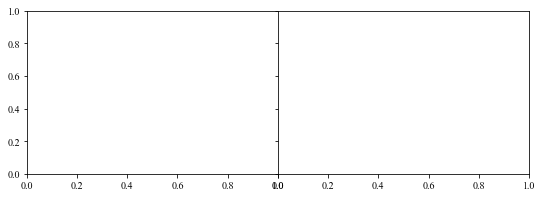

In [38]:
wd = 3

data_skip = 1#int((len(test_t2s)-1)/3)
print(data_skip)

good_indices = [0]

good_indices = [0]

for kk in range(1,len(test_t2s)):
    this_index = good_indices[-1] + data_skip
    
    if this_index>len(test_t2s):
        break
    else:
        good_indices.append(this_index)
    
print(good_indices)

#l = int((len(test_t2s)-1)*wd)

l = int(len(good_indices)*wd)

fig = plt.figure(figsize=(l,wd))
gs = fig.add_gridspec(ncols=len(good_indices)-1, nrows=1, wspace=0)

axs = gs.subplots(sharex=True,sharey=True)

all_aucs = []

test_t2s = test_t2s[::-1]

#for k in range(0,len(test_t2s)-1):
for ik in range(0,len(good_indices)-1):
    k = good_indices[ik]
    #print(test_t2s[k],test_t2s[k+1])
    
    #dx = copy.deepcopy(cdfs[test_t2s[k]][::-1])
    #dy = copy.deepcopy(cdfs[test_t2s[k+1]][::-1])
    
    all_aucs.append(auc(cdfs[test_t2s[k+1]][::-1],cdfs[test_t2s[k]][::-1]))
    
    #all_aucs.append(auc(dx_2,dy_2))
    
    label_text = str(round(all_aucs[-1],3))
    
    #axs[ik].plot(cdfs[test_t2s[k+1]],cdfs[test_t2s[k]],lw=2,color='black',label=label_text)
    #axs[ik].fill_between(cdfs[test_t2s[k+1]],0,cdfs[test_t2s[k]],color='black',alpha=0.3)#,label=str(test_t2s[k])+' h',alpha=_alpha)
    #axs[ik].set_xticks((0,1))
    #axs[ik].set_yticks((0,1))
    #axs[ik].tick_params(axis='both',labelsize=16)
    #axs[ik].legend(frameon=False,prop={'size': 18,'family':'Arial'},markerscale=1.0,handlelength=0.0,loc='lower right')
    #axs[ik].set_title(str(test_t2s[k+1])+'h - '+str(test_t2s[k])+'h',fontsize=16)
    
    #if k%2==0:
    #    axs[k].xaxis.tick_top()
    
        
        
    #axs[k].set_title('AUC = '+str(round(all_aucs[-1],3)),fontsize=16)
    
        
#print(max(all_aucs))
#plt.tight_layout()
#plt.savefig('ALA-AUC-24h.png',dpi=300)  

try:
    wf = open('min_AUC_summary.csv','a')
    wf.close()
except FileNotFoundError:
    wf = open('min_AUC_summary.csv','w')
    wf.close()
    
print(str(abs(round(test_t2s[0]-test_t2s[1],0)))+','+str(round(max(all_aucs),2)),file=open('min_AUC_summary.csv','a'))

In [ ]:
popt, pcov = optim.curve_fit(Annexinfunc,all_data[tag],all_data['T2'])
print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)

In [ ]:
aa1 = np.linspace(15,70,100)
T2aa1 = Annexinfunc(aa,popt[0],popt[1])

errs = all_data['T2'][:6] - Annexinfunc(all_data[tag][:6],popt[0],popt[1])

chi = math.sqrt((np.linalg.norm(errs,ord=2)**2)/errs.shape[0])

print(chi)

In [ ]:
popt, pcov = optim.curve_fit(Annexinfunc,all_data[tag][6:],all_data['T2'][6:])
print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)

In [ ]:
aa2 = np.linspace(15,70,100)
T2aa2 = Annexinfunc(aa,popt[0],popt[1])

errs = all_data['T2'][:6] - Annexinfunc(all_data[tag][6:],popt[0],popt[1])

chi = math.sqrt((np.linalg.norm(errs,ord=2)**2)/errs.shape[0])

print(chi)

In [ ]:
popt, pcov = optim.curve_fit(Annexinfunc,all_data[tag],all_data['T2'])
print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)

aa = np.linspace(10,80,100)
T2aa = Annexinfunc(aa,popt[0],popt[1])

errs = all_data['T2'][:6] - Annexinfunc(all_data[tag][6:],popt[0],popt[1])

chi = math.sqrt((np.linalg.norm(errs,ord=2)**2)/errs.shape[0])

print(chi)

In [ ]:
err_data = pd.read_csv('Annexin24h_error.csv',header=None).to_numpy()
#err_data = pd.read_csv('Annexin0h_error.csv',header=None).to_numpy()

T2s = err_data[:,0]
err_cI = np.zeros(shape=(err_data.shape[0],2))

for i in range(0,err_data.shape[0]):
    err_cI[i,0] = np.mean(err_data[i,1:])
    
    CI = st.t.interval(alpha=0.95, df=len(err_data[i,1:])-1, loc=err_cI[i,0], scale=st.sem(err_data[i,1:]))
    
    err_cI[i,1] = 0.5*(CI[1] - CI[0])

In [ ]:
fig, axs = plt.subplots(figsize=(7,6))

off = 36

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

plt.errorbar(err_cI[off:off+6,0],T2s[:6],yerr=None,xerr=err_cI[off:off+6,1],fmt='.',lw=2,alpha=0.5,mew=2,ms=1,color='#000000',capsize=5,capthick=1)
plt.errorbar(err_cI[off+6:off+12,0],T2s[6:12],yerr=None,xerr=err_cI[off+6:off+12,1],fmt='.',lw=2,alpha=0.5,mew=2,ms=1,color='#000000',capsize=5,capthick=1)

plt.scatter(err_cI[off:off+6,0],T2s[:6],marker='o',linewidth=0,s=100,c=colors1)
plt.scatter(err_cI[off+6:off+12,0],T2s[6:12],marker='^',linewidth=0,s=100,c=colors1)

plt.scatter(err_cI[off+5,0],T2s[5],marker='o',s=100,c='black',label='Study 1')
plt.scatter(err_cI[off+11,0],T2s[11],marker='^',s=100,c='black',label='Study 2')

plt.xticks(size=20)
plt.yticks(size=20)  
#plt.xlabel('Healthy cells (%)',size=22)
#plt.xlabel('Early apoptotic cells (%)',size=22)
#plt.xlabel('Late apoptotic cells (%)',size=22)
plt.xlabel('Necrotic cells (%)',size=22)

plt.ylabel(r'T2 (h)',size=22,rotation=90)
plt.minorticks_on()
#plt.xlim(90,100)
plt.ylim(50,300)
axs.tick_params(which='major', length=8)
axs.tick_params(which='minor', length=4)
plt.legend(frameon=True,prop={'size': 16},markerscale=1.0,handlelength=1.0,loc='upper right')
plt.tight_layout()

#plt.savefig('healthy-24h_err.png',dpi=300)
#plt.savefig('early_apoptotic-24h_err.png',dpi=300)
#plt.savefig('late_apoptotic-24h_err.png',dpi=300)
plt.savefig('necrotic-24h_err.png',dpi=300)

In [ ]:
rgba_colors = 0.5*np.ones((6,4))
alphas = np.linspace(0.1, 1, 6)
rgba_colors[:,3] = alphas
rgba_colors[:,3] = alphas
print(v0.shape)

print(v0[10:,3],v0[10:,0])

In [ ]:
weight1 = pd.Series([0.2, 0.3, 0.5, 0.7])
colors1 = weight1.apply(lambda x: (0,0,0,x)).tolist()

weight2 = pd.Series([0.2, 0.5, 0.7])
colors2 = weight2.apply(lambda x: (0,0,0,x)).tolist()

weight3 = pd.Series([0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
colors3 = weight3.apply(lambda x: (0,0,0,x)).tolist()

In [ ]:
fig, axs = plt.subplots(figsize=(7,6))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

#plt.errorbar(v0[:,0],v0[:,3],v0[:,4],v0[:,1],fmt='o',lw=2,alpha=0.5,mew=2,ms=10,color='#000000',capsize=5,capthick=1,label='0 h')
plt.scatter(v0[:4,3],v0[:4,0],marker='o',s=80,c=colors1,label='Study 1')
plt.scatter(v0[4:7,3],v0[4:7,0],marker='^',s=80,c=colors2,label='Study 6')
plt.scatter(v0[7:,3],v0[7:,0],marker='s',s=80,c=colors3,label='Study 5')
#plt.plot(v0[:,3],v0[:,0],marker='o',linewidth=0,ms=8,c=rgba_colors,mew=0)
#plt.plot(aa,T2aa,linewidth=2,color='#000000',alpha=0.5,label=r'$(518.3 \pm 76.1) - (4.6 \pm 0.9)[A_H]$')

#plt.errorbar(v24[:,0],v24[:,3],v24[:,4],v24[:,1],fmt='^',lw=2,alpha=0.5,mew=2,ms=10,color='r',capsize=5,capthick=1,label='24 h')
#plt.plot(v24[:,0],v24[:,3],marker='o',linewidth=0,ms=8,color='c',alpha=0.7,label='24 h',mew=0)
#plt.plot(tb24,ts24,linewidth=1.5,color='c',alpha=0.9,label=r'460$(1-e^{-0.09[\mathrm{TBlue}]})$')
#plt.fill_between(tb24,t_ll24,t_ul24,color='c',alpha=0.2)

#plt.errorbar(v48[:,0],v48[:,3],v48[:,4],v48[:,1],fmt='d',lw=2,alpha=0.7,mew=2,ms=7,color='m',capsize=5,capthick=1,label='48 h')
#plt.plot(v48[:,0],v48[:,3],marker='o',linewidth=0,ms=8,color='m',alpha=0.7,label='48 h',mew=0)

#plt.errorbar(v72[:,0],v72[:,3],v72[:,4],v72[:,1],fmt='^',lw=3,alpha=0.7,mew=2,ms=7,color='y',capsize=5,capthick=1,label='72 h')
#plt.plot(v72[:,0],v72[:,3],marker='o',linewidth=0,ms=8,color='y',alpha=0.7,label='72 h',mew=0)

plt.xticks(size=20)
plt.yticks(size=20)  
plt.xlabel(r'AO/DAPI (AHT)',size=22)
plt.ylabel(r'T2 (h)',size=22,rotation=90)
plt.minorticks_on()
plt.xlim(90,100)
plt.ylim(50,250)
axs.tick_params(which='major', length=8)
axs.tick_params(which='minor', length=4)
plt.legend(frameon=False,prop={'size': 16},markerscale=1.0,handlelength=1.0,loc='lower left')
plt.tight_layout()

plt.savefig('CombinedAnnexinHealthy-165.png',dpi=600)

In [ ]:
popt, pcov = optim.curve_fit(Annexinfunc,v0[:,4],v0[:,0])
print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)

ae = np.linspace(0,20,100)
T2ae = Annexinfunc(ae,popt[0],popt[1])

In [ ]:
fig, axs = plt.subplots(figsize=(7,6))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

#plt.errorbar(v0[:,0],v0[:,3],v0[:,4],v0[:,1],fmt='o',lw=2,alpha=0.5,mew=2,ms=10,color='#000000',capsize=5,capthick=1,label='0 h')
plt.plot(v0[:6,4],v0[:6,0],marker='o',linewidth=0,ms=8,color='r',alpha=0.7,label=r'Early apoptotic $(A_E)$',mew=0)
plt.plot(v0[6:10,4],v0[6:10,0],marker='^',linewidth=0,ms=8,color='r',alpha=0.7,mew=0)
plt.plot(v0[10:,4],v0[10:,0],marker='s',linewidth=0,ms=8,color='r',alpha=0.7,mew=0)

plt.plot(v0[:6,5],v0[:6,0],marker='o',linewidth=0,ms=8,color='g',alpha=0.7,label='Late apoptotic',mew=0)
plt.plot(v0[6:10,5],v0[6:10,0],marker='^',linewidth=0,ms=8,color='g',alpha=0.7,mew=0)
plt.plot(v0[10:,5],v0[10:,0],marker='s',linewidth=0,ms=8,color='g',alpha=0.7,mew=0)

plt.plot(v0[:6,6],v0[:6,0],marker='o',linewidth=0,ms=8,color='b',alpha=0.7,label='Necrotic',mew=0)
plt.plot(v0[6:10,6],v0[6:10,0],marker='^',linewidth=0,ms=8,color='b',alpha=0.7,mew=0)
plt.plot(v0[10:,6],v0[10:,0],marker='s',linewidth=0,ms=8,color='b',alpha=0.7,mew=0)

plt.plot(ae,T2ae,linewidth=2,color='r',alpha=0.5,label=r'$(76 \pm 14.1) + (9.7 \pm 1.9)[A_E]$')

#plt.errorbar(v24[:,0],v24[:,3],v24[:,4],v24[:,1],fmt='^',lw=2,alpha=0.5,mew=2,ms=10,color='r',capsize=5,capthick=1,label='24 h')
#plt.plot(v24[:,0],v24[:,3],marker='o',linewidth=0,ms=8,color='c',alpha=0.7,label='24 h',mew=0)
#plt.plot(tb24,ts24,linewidth=1.5,color='c',alpha=0.9,label=r'460$(1-e^{-0.09[\mathrm{TBlue}]})$')
#plt.fill_between(tb24,t_ll24,t_ul24,color='c',alpha=0.2)

#plt.errorbar(v48[:,0],v48[:,3],v48[:,4],v48[:,1],fmt='d',lw=2,alpha=0.7,mew=2,ms=7,color='m',capsize=5,capthick=1,label='48 h')
#plt.plot(v48[:,0],v48[:,3],marker='o',linewidth=0,ms=8,color='m',alpha=0.7,label='48 h',mew=0)

#plt.errorbar(v72[:,0],v72[:,3],v72[:,4],v72[:,1],fmt='^',lw=3,alpha=0.7,mew=2,ms=7,color='y',capsize=5,capthick=1,label='72 h')
#plt.plot(v72[:,0],v72[:,3],marker='o',linewidth=0,ms=8,color='y',alpha=0.7,label='72 h',mew=0)

plt.xticks(size=20)
plt.yticks(size=20)  
plt.xlabel(r'Annexin',size=22)
plt.ylabel(r'T2 (h)',size=22,rotation=90)
plt.minorticks_on()
#plt.xlim(70,100)
plt.ylim(50,300)
axs.tick_params(which='major', length=8)
axs.tick_params(which='minor', length=4)
plt.legend(frameon=False,prop={'size': 14},markerscale=1.0,handlelength=1.0,loc='upper left')
plt.tight_layout()

plt.savefig('CombinedAnnexin-all-30.png',dpi=600)

In [ ]:
xs = v_data['AODAPI'].to_numpy()
max_atp = np.max(xs)
print(xs)

In [ ]:
x_data = np.zeros(shape=(n_data*xs.shape[0],))
y_data = np.zeros(shape=(n_data*xs.shape[0],))

n = 0

for k in list(v_data):
    if 'T2' in k:
        x_data[n:n+xs.shape[0]] = xs #- ATP_offset
        y_data[n:n+xs.shape[0]] = v_data[k].to_numpy()
        
        n += xs.shape[0]
        
print(x_data,y_data)